In [11]:
import os

from shapely import wkb
import geopandas as gpd
import pandas as pd
import numpy as np
import duckdb

## Download sample data

#### AWS configuration

In [ ]:
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''
os.environ['AWS_SESSION_TOKEN'] = ''

S3_REGION = 'us-west-2'

#### Initialize DuckDB, install & load extensions

In [257]:
con = duckdb.connect()

# Install & load the HTTPFS extension for S3 access
con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")

con.execute("INSTALL spatial;")
con.execute("LOAD spatial;")

# Configure
con.execute(f"SET s3_region='{S3_REGION}';")


### Fetch data

In [ ]:
for area_range in ['0-10', '10-15']:
    s3_prefix = f"s3://omf-internal-usw2/staging/buildings_test_alex_2025_06_02/area_test/area={area_range}/*"

    # Approximate Bernoulli sample (~0.01% of rows, faster for huge datasets)
    query_approx = f"""
    SELECT *
    FROM parquet_scan('{s3_prefix}')
    TABLESAMPLE BERNOULLI (0.01 PERCENT)
    LIMIT 1000;
    """

    gdf = con.execute(query_approx).df()

    gdf['geometry'] = gdf['geometry'].apply(lambda x: wkb.loads(bytes(x), hex=True))
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs='EPSG:4326')
    gdf.to_parquet(f'data/small-buildings-{area_range}-sample.parquet')

In [19]:
gdf.centroid.explore()

/var/folders/jk/rndbblbs2fs0_symsqry30400000gn/T/ipykernel_27248/2761476076.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.explore()
/Users/fnachtigall/workspace/omf-playground/buildings/.venv/lib/python3.11/site-packages/numba/cpython/old_hashing.py:477: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


## Filter footprints with high-resolution imagery

In [ ]:
gdf = gpd.read_parquet('data/small-buildings-10-15-sample.parquet')

In [ ]:
import geopandas as gpd
import mercantile
import requests

ESRI_TILE_URL = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
ZOOM = 19
NO_DATA_LAT = 85.05112878  # known “no imagery” latitude

def get_tile_url(x, y, z=ZOOM):
    return ESRI_TILE_URL.format(z=z, y=y, x=x)

def fetch_length(url, timeout=5):
    try:
        r = requests.head(url, timeout=timeout)
        if cl := r.headers.get("Content-Length"):
            return int(cl)
        return len(requests.get(url, timeout=timeout).content)
    except requests.RequestException:
        return None

def lonlat_to_tile(lon, lat, z=ZOOM):
    return mercantile.tile(lon, lat, z)

def has_real_imagery(x, y, placeholder):
    length = fetch_length(get_tile_url(x, y))
    return (length is not None) and (length != placeholder)


# 1. Get placeholder size
no_data_tile = lonlat_to_tile(0, NO_DATA_LAT)
placeholder = fetch_length(get_tile_url(no_data_tile.x, no_data_tile.y))
assert placeholder is not None, "Failed to fetch placeholder tile size"

# 2. Load data, compute centroid & tile index
gdf["centroid"] = gdf.geometry.centroid
gdf["tile"] = gdf.centroid.apply(lambda pt: lonlat_to_tile(pt.x, pt.y))

# 3. Flag rows with real zoom-19 imagery
gdf["has_sat_z19"] = gdf["tile"].apply(lambda t: has_real_imagery(t.x, t.y, placeholder))

# 4. Filter and save high-res buildings
gdf_high_res = gdf[gdf["has_sat_z19"].fillna(False)]
gdf_high_res = gdf_high_res[['id', 'geometry']].set_index('id')
gdf_high_res.to_parquet('data/small-buildings-hq-10-15-sample.parquet')

/var/folders/jk/rndbblbs2fs0_symsqry30400000gn/T/ipykernel_46973/397804751.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid"] = gdf.geometry.centroid
/var/folders/jk/rndbblbs2fs0_symsqry30400000gn/T/ipykernel_46973/397804751.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["tile"] = gdf.centroid.apply(lambda pt: lonlat_to_tile(pt.x, pt.y))


In [ ]:
gdf_high_res.centroid.explore()

/var/folders/jk/rndbblbs2fs0_symsqry30400000gn/T/ipykernel_51488/683261734.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_high_res.centroid.explore()


In [32]:
gdf_high_res.sample(1).explore(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri World Imagery",
    color="red",
    zoom=19,
)

/Users/fnachtigall/workspace/omf-playground/buildings/.venv/lib/python3.11/site-packages/numba/cpython/old_hashing.py:477: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


## Manual labeling

In [ ]:
from IPython import display
import ipywidgets as widgets
from ipyevents import Event
import folium

gdf = gpd.read_parquet('data/small-buildings-hq-10-15-sample.parquet')

progress_file = 'data/labeling-progress.csv'

# Load progress if exists
if os.path.exists(progress_file):
    results = pd.read_csv(progress_file).to_dict('records')
else:
    results = []

already_labeled_ids = [item['id'] for item in results]
candidates = gdf.drop(already_labeled_ids)


def show_duplicate_candidate(i):
    """Display a potential building duplicate and its neighbors for labeling"""
    if i >= len(candidates):
        print("All buildings labeled!")
        return

    # Clear output to refresh map and widgets
    display.clear_output(wait=True)
    
    _display_map(i)
    _display_buttons(lambda label: _on_button_click(i, label))


def _display_buttons(action):
    """Display buttons for labeling"""
    yes_button = widgets.Button(description="Building", button_style="success")
    no_button = widgets.Button(description="Not a Building", button_style="danger")
    unsure_button = widgets.Button(description="Unsure", button_style="info")
    
    yes_button.on_click(lambda _: action("yes"))
    no_button.on_click(lambda _: action("no"))
    unsure_button.on_click(lambda _: action("unsure"))
    
    hbox = widgets.HBox([yes_button, no_button, unsure_button])

    # create an Event watcher on that container
    key_events = Event(
        source=hbox,
        watched_events=["keydown"]
    )
    def handle_key(event):
        key = event.get("key", "").lower()
        if key == "y":
            yes_button.click()
        elif key == "n":
            no_button.click()
        elif key == "u":
            unsure_button.click()
        # prevent notebook scrolling on spacebar, etc.
        event["preventDefault"] = True

    key_events.on_dom_event(handle_key)
    display.display(hbox)


def _display_map(i):
    """Display map with candidate building"""
    candidate = candidates.iloc[i]
    centroid = candidate.geometry.centroid
    lng, lat = centroid.y, centroid.x
    m = folium.Map(location=[lng, lat], zoom_start=20, show=False)

    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Esri World Imagery",
        max_native_zoom=19,
        max_zoom=20,
        show=True,
        overlay=False,
    ).add_to(m)

    # Highlight candidate building with red boundary
    m = candidates.iloc[[i]].explore(color="red", m=m, style_kwds={"fillOpacity": 0, "weight": 1.5})

    display.display(m)


def _on_button_click(i, label):
    id = candidates.iloc[i].name
    results.append({"id": id, "label": label})
    _store_progress()
    show_duplicate_candidate(i + 1)  # Move to next pair
    

def _store_progress():
    results_df = pd.DataFrame(results)
    results_df.to_csv(progress_file)


show_duplicate_candidate(0)

In [ ]:
df_labels = pd.read_csv('data/small-buildings-labels.csv', index_col=0).set_index('id')
gdf['label'] = df_labels['label']
gdf.to_parquet('data/small-buildings-hq-10-15-sample-w-labels.parquet')

In [20]:
gdf['label'].value_counts()

label
unsure    89
yes       47
no        35
Name: count, dtype: int64

## Evaluation

### Calculate shape characteristics

In [12]:
import math
from shapely.geometry import Polygon
import momepy


def isoperimetric_quotient(poly: Polygon) -> float:
    A = poly.area
    P = poly.length
    return 4 * math.pi * A / (P * P)

def calculate_car_similarity(fts):
    ref_elong = 0.5
    ref_area = 15
    ref_conv = 1

    return (((fts['footprint_area'] - ref_area).abs() / ref_area +
            (fts['elongation'] - ref_elong).abs() / ref_elong * 3 +
            (fts['convexity'] - ref_conv).abs() / ref_conv * 5) / 3).clip(upper=1)

features = ['footprint_area', 'perimeter', 'corners', 'longest_axis_length', 'elongation', 'orientation', 'rectangularity', 'squareness', 'convexity', 'area_perimeter_ratio', 'iq', 'shape_index', 'car_similarity']

gdf = gpd.read_parquet('data/small-buildings-hq-10-15-sample-w-labels.parquet')

# Single global CRS (results in biased)
gdf = gdf.to_crs('ESRI:54034')
gdf.geometry = gdf.buffer(0).simplify(tolerance=0.1)
gdf["footprint_area"] = gdf.area
gdf["perimeter"] = gdf.length
gdf["corners"] = momepy.corners(gdf, eps=45)
gdf["longest_axis_length"] = momepy.longest_axis_length(gdf)
gdf["elongation"] = momepy.elongation(gdf)
gdf["orientation"] = momepy.orientation(gdf)
gdf["rectangularity"] = momepy.rectangularity(gdf)
gdf["squareness"] = momepy.squareness(gdf)
gdf["convexity"] = momepy.convexity(gdf)
gdf["area_perimeter_ratio"] = gdf["footprint_area"] / gdf["perimeter"]
gdf['iq'] = gdf.geometry.apply(isoperimetric_quotient)
gdf["shape_index"] = momepy.shape_index(gdf, longest_axis_length=gdf["longest_axis_length"])
gdf["car_similarity"] = calculate_car_similarity(gdf)


gdf_val = gdf[gdf['label'].isin(['yes', 'no'])]


In [13]:
def compute_metrics_local_crs(group):
    group_proj = group.to_crs(f"EPSG:{group.name}")

    metrics = pd.DataFrame({
        'footprint_area':        group_proj.geometry.area,
        'perimeter':             group_proj.geometry.length,
        'corners':               momepy.corners(group_proj),
        'longest_axis_length':   momepy.longest_axis_length(group_proj),
        'elongation':            momepy.elongation(group_proj),
        'orientation':           momepy.orientation(group_proj),
        'rectangularity':        momepy.rectangularity(group_proj),
        'squareness':            momepy.squareness(group_proj),
        'convexity':             momepy.convexity(group_proj),
        'area_perimeter_ratio':  group_proj.geometry.area / group_proj.geometry.length,
        'iq':                    group_proj.geometry.apply(isoperimetric_quotient),
        'shape_index':           momepy.shape_index(group_proj, \
                                        longest_axis_length= momepy.longest_axis_length(group_proj)),
    }, index=group.index)

    metrics['car_similarity'] = calculate_car_similarity(metrics)

    return metrics


def utm_crs_series(lons, lats):
    # calculate UTM zone number (1 to 60)
    zones = ((lons + 180) // 6 + 1).astype(int)
    # EPSG prefix: 326 for northern hemisphere, 327 for southern
    prefix = np.where(lats >= 0, '326', '327')
    # compose full EPSG codes as strings, e.g. '32632'
    return prefix + zones.astype(str).str.zfill(2)


gdf = gpd.read_parquet('data/small-buildings-hq-10-15-sample-w-labels.parquet')

gdf["lon"] = gdf.geometry.centroid.x
gdf["lat"] = gdf.geometry.centroid.y
gdf["utm_crs"] = utm_crs_series(gdf["lon"], gdf["lat"])

gdf = gdf.assign(**gdf.groupby('utm_crs', group_keys=False)
                 .apply(compute_metrics_local_crs)
                 )

gdf_val = gdf[gdf['label'].isin(['yes', 'no'])]

/var/folders/jk/rndbblbs2fs0_symsqry30400000gn/T/ipykernel_51488/473718411.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/var/folders/jk/rndbblbs2fs0_symsqry30400000gn/T/ipykernel_51488/473718411.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y
/var/folders/jk/rndbblbs2fs0_symsqry30400000gn/T/ipykernel_51488/473718411.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after 

### Inspect similarity visually

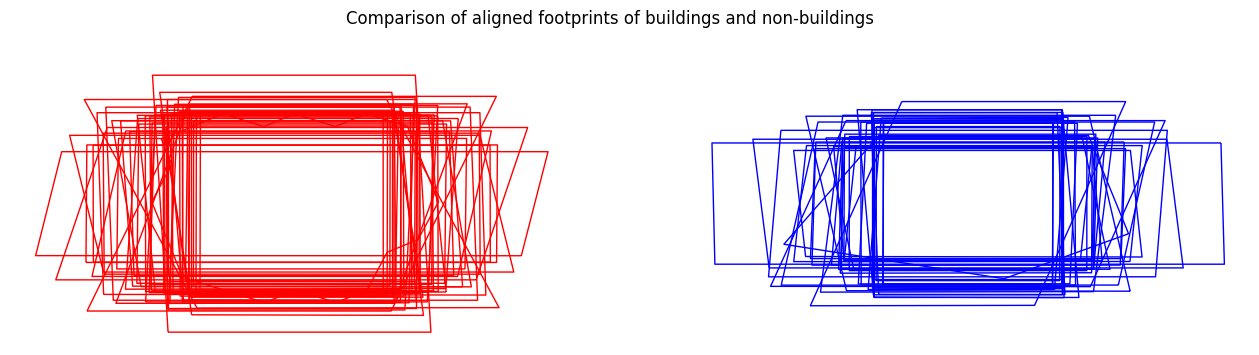

In [16]:
import math
import geopandas as gpd
from shapely.affinity import translate, rotate
import matplotlib.pyplot as plt

def align_longest_axis(poly):
    # 1) center on centroid
    c = poly.centroid
    centered = translate(poly, xoff=-c.x, yoff=-c.y)

    # 2) compute its minimum bounding rectangle
    mbr = centered.minimum_rotated_rectangle
    # get the 4 corners (last pt = first pt)
    pts = list(mbr.exterior.coords)[:-1]

    # 3) find the longest edge in the rectangle
    max_len = 0.0
    best_angle = 0.0
    for i in range(len(pts)):
        x1, y1 = pts[i]
        x2, y2 = pts[(i+1) % len(pts)]
        dx, dy = x2 - x1, y2 - y1
        L = math.hypot(dx, dy)
        if L > max_len:
            max_len = L
            best_angle = math.degrees(math.atan2(dy, dx))

    # 4) rotate so that edge becomes horizontal
    aligned = rotate(centered, -best_angle, origin=(0, 0))
    return aligned

gdf_a = gdf[gdf['label'] == 'yes'].copy()
gdf_b = gdf[gdf['label'] == 'no'].copy()

gdf_a['aligned'] = gdf_a.geometry.apply(align_longest_axis)
gdf_b['aligned'] = gdf_b.geometry.apply(align_longest_axis)


fig, ax = plt.subplots(ncols=2, figsize=(16, 4))
gdf_a.set_geometry('aligned').plot(ax=ax[0], edgecolor='red', facecolor='none', linestyle='-', label='Set A')
gdf_b.set_geometry('aligned').plot(ax=ax[1], edgecolor='blue', facecolor='none', linestyle='-', label='Set B')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].axis('off')
ax[1].axis('off')

fig.suptitle('Comparison of aligned footprints of buildings and non-buildings')
plt.show()

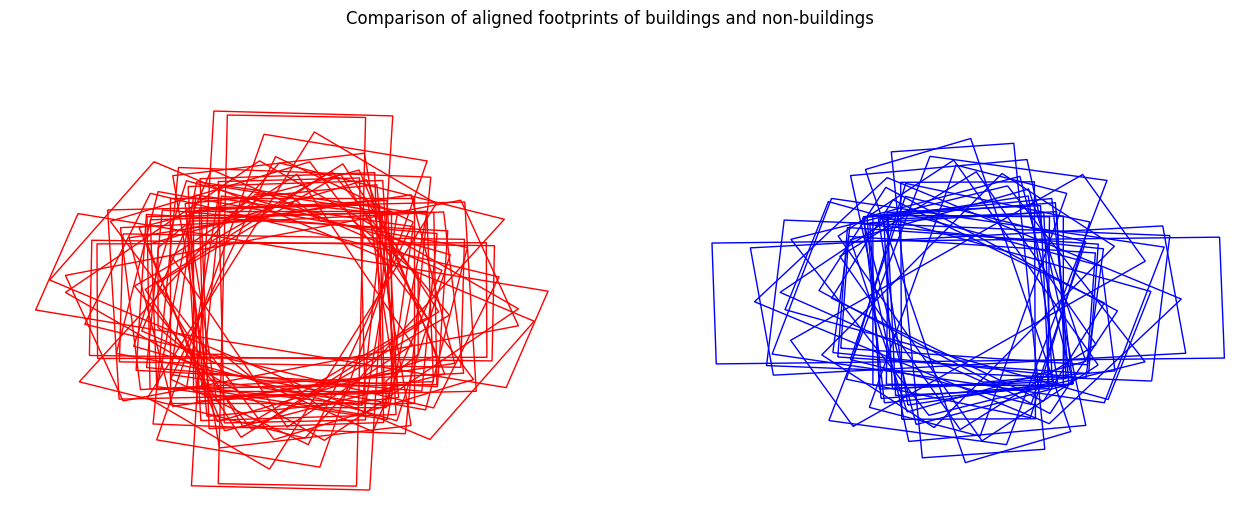

In [8]:
from shapely.affinity import translate, rotate

def center(poly):
    # 1. Center polygon at origin
    c = poly.centroid
    centered = translate(poly, xoff=-c.x, yoff=-c.y)

    return centered

def aligned_orientation(gdf):
    gdf['orientation'] = momepy.orientation(gdf)
    aligned = gdf.apply(lambda row: rotate(row['geometry'], -row['orientation'], origin=(0, 0)), axis=1)

    return aligned

# Split your GeoDataFrame by label
gdf_a = gdf[gdf['label'] == 'yes'].copy()
gdf_b = gdf[gdf['label'] == 'no'].copy()

# Apply alignment
gdf_a['aligned'] = gdf_a.geometry.apply(center)
gdf_b['aligned'] = gdf_b.geometry.apply(center)

# Plot overlay of aligned boundaries using GeoPandas plotting
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
gdf_a.set_geometry('aligned').plot(ax=ax[0], edgecolor='red', facecolor='none', linestyle='-', label='Set A')
gdf_b.set_geometry('aligned').plot(ax=ax[1], edgecolor='blue', facecolor='none', linestyle='-', label='Set B')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].axis('off')
ax[1].axis('off')

fig.suptitle('Comparison of aligned footprints of buildings and non-buildings')
plt.show()

In [58]:
gdf[gdf['label'] == 'no'].sample(1).explore(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri World Imagery",
    color="red",
    zoom_start=20,
)

/Users/fnachtigall/workspace/omf-playground/buildings/.venv/lib/python3.11/site-packages/numba/cpython/old_hashing.py:477: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


### Inspect similarity quantitatively 

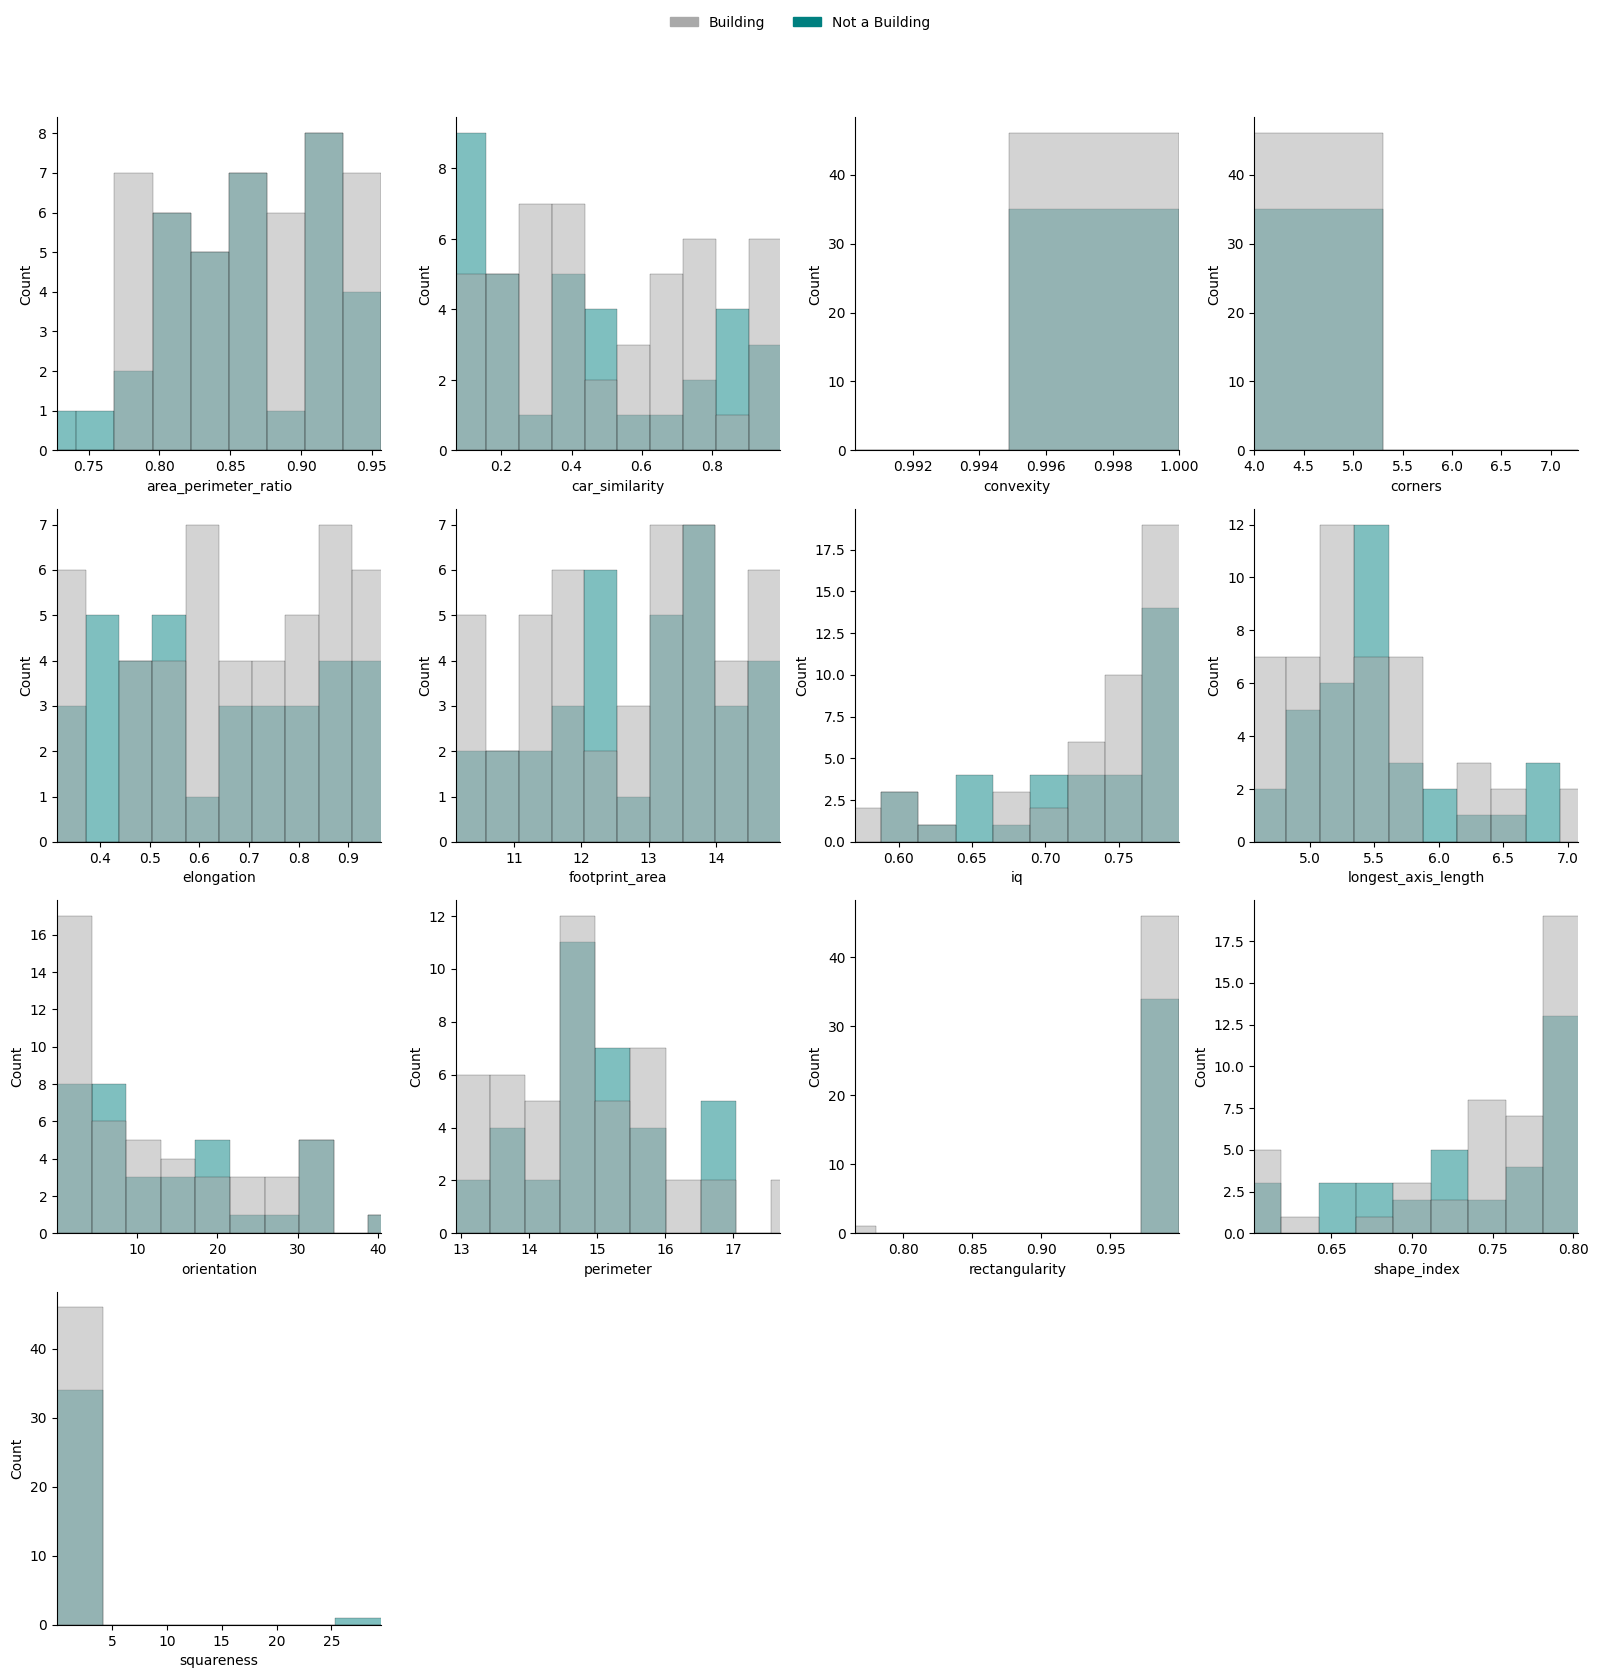

In [15]:
import seaborn as sns
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches

vars_to_plot = features
hue_var = 'label'
df_long = pd.melt(gdf_val, id_vars=[hue_var], value_vars=vars_to_plot)

cat_type = CategoricalDtype(categories=['yes', 'no'], ordered=True)
df_long['label'] = df_long['label'].astype(cat_type)


colors = ['darkgrey', 'teal']
category_labels = {'yes': 'Building', 'no': 'Not a Building'}

g = sns.FacetGrid(
    df_long.sort_values('variable'),
    col="variable",
    sharex=False,
    sharey=False,
    col_wrap=4,
    height=4
)

g.map_dataframe(
    sns.histplot,
    "value",
    hue=hue_var,
    hue_order=cat_type.categories,
    palette=colors,
    bins=10,
    linewidth=0.15,
    # multiple='fill',
    multiple='layer',
    stat='count'
)

for ax, (var, subdata) in zip(g.axes.flat, df_long.groupby("variable")):
    ax.set_title("")
    ax.set_xlabel(var)
    p5, p95 = np.percentile(subdata["value"].dropna(), [1, 99])
    ax.set_xlim(p5, p95)


# Create custom legend
handles = [
    mpatches.Patch(color=colors[i], label=category_labels[lab])
    for i, lab in enumerate(cat_type.categories)
]
g.fig.legend(
    handles=handles,
    title="",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=3,
    frameon=False
)

g.add_legend()
plt.show()

### Attempt to classify based on shape characteristics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

metric_thresholds = {
    'iq': 0.75,
    'rectangularity': 0.75,
    # add further potentially decisive metrics of interest
}

for metric, threshold in metric_thresholds.items():
    y_true = gdf_val['label'] == 'yes'
    y_pred = gdf_val[metric] >= threshold
    f1 = f1_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['no', 'yes'])
    cm = confusion_matrix(y_true, y_pred)

    print(f'F1 score for metric "{metric}": {f1:.3f}')
    print(report)
    print(cm)



F1 score for metric "iq": 0.578
              precision    recall  f1-score   support

          no       0.46      0.51      0.49        35
         yes       0.60      0.55      0.58        47

    accuracy                           0.54        82
   macro avg       0.53      0.53      0.53        82
weighted avg       0.54      0.54      0.54        82

[[18 17]
 [21 26]]
F1 score for metric "rectangularity": 0.734
              precision    recall  f1-score   support

          no       1.00      0.03      0.06        35
         yes       0.58      1.00      0.73        47

    accuracy                           0.59        82
   macro avg       0.79      0.51      0.39        82
weighted avg       0.76      0.59      0.44        82

[[ 1 34]
 [ 0 47]]


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GroupKFold


model = xgb.XGBClassifier(random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

X = gdf_val[features]
y = gdf_val['label'] == 'yes'

gdf_val['y_pred'] = cross_val_predict(model, X, y, cv=kfold)
report = classification_report(y, gdf_val['y_pred'])
print(report)


              precision    recall  f1-score   support

       False       0.38      0.34      0.36        35
        True       0.54      0.57      0.56        47

    accuracy                           0.48        82
   macro avg       0.46      0.46      0.46        82
weighted avg       0.47      0.48      0.47        82



/Users/fnachtigall/workspace/omf-playground/buildings/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
